# Projet de programmation  :
# L'union fait la force : optimisation par colonie de fourmis 
*Sacha Apelbaum et Corentin Pernot, Projet Python 1A ENSAE*


# Introduction 

En étudiant le comportement social des fourmis, il semble que ces dernières ont compris que "l'union faisait la force". En effet, leur comportement est collectif dans la mesure où chaque fourmi a pour priorité le bien-être de la communauté. Individuellement, les fourmis possèdent des capacités cognitives limitées, mais leur utilisation des phéromones permet l'apparition d'une intelligence collective, nommée la Swarm Intelligence (intelligence en essaim).

Lorsqu'une fourmi recherche de la nourriture depuis son nid, elle libère, au cours de son chemin, des molécules chimiques appelées phéromones que les autres fourmis peuvent détecter grâce à des capteurs sur leurs antennes. Ainsi, les phéromones permettent de marquer un chemin car les fourmis sont attirées par la piste contenant la plus forte concentration de phéromones. Petit à petit, les fourmis vont donc consolider la piste du chemin à suivre.  Le chemin du nid vers la nourriture sera alors tracé au fur et à mesure : elles pourront donc trouver le chemin le plus court vers la nourriture lorsqu'elles fonctionnent en colonie. 

Nous avons donc voulu modéliser une imitation du comportement des colonies de fourmis afin de résoudre des problèmes complexes. Tout d'abord, nous étudierons, à l'aide d'un modèle simple, comment les fourmis choisissent le chemin le plus court de leur nid vers la nourriture. Puis, nous étudierons en quoi le principe des colonies de fourmis et de leurs phéromones permet de résoudre un problème complexe connu sous le nom de "Problème du voyageur de commerce" ("Travelling Salesman Problem"). 

# I ) Le principe de fonctionnement des phéromones

Pour comprendre l’impact des phéromones sur le comportement des fourmis, certains chercheurs comme Deneubourg ont réalisé différentes expériences permettant d’élaborer un modèle comportemental mathématique applicable aux algorithmes d’optimisation. 

## 1 ) Le pont binaire de Deneubourg 

L’expérience la plus connue est celle du pont binaire de Deneubourg. Elle montre un nid d’une colonie de fourmis séparé d’une source de nourriture par un pont constitué de deux chemins de longueur identique.

Nous n'arrivions pas à mettre l'image explicative sur le notebook;  il s'agit de la première photo sur Google en tapant "Pont binaire de Deneubourg"

Au départ, il n’y a aucune trace de phéromone sur les deux branches du pont. Ainsi, chaque branche peut être choisie avec la même probabilité. 
Après une période de fluctuations, à cause de certaines variations aléatoires, la quantité de phéromones a tendance à s’accumuler sur l’une des deux branches. 
Puisque l’un des chemins contient plus de phéromones que l’autre, les fourmis sont incitées à prendre celui-ci. 
Cette expérience met en avant le fait que plus un chemin est suivi, plus la probabilité pour la fourmi de choisir ce chemin est élevée et donc  plus ce chemin s’avère intéressant à suivre. 

La modélisation que nous avons choisie ici est la suivante : on dispose d’un nid associé au point A et d’une source de nourriture associée au point B. Deux chemins relient le point A au point B, le chemin C1 et le chemin C2, ici supposés de longueur identique. 

A chaque itération, D fourmis sortent du nid (on peut associer D au débit). D’autre part, les fourmis se déplacent d’une longueur v à chaque itération (on peut associer v à la vitesse des fourmis). De plus, chaque fourmi choisit de prendre le chemin C1 avec une probabilité p. On considère que les fourmis se trouvant au même point font des choix indépendants. Ainsi, la variable aléatoire modélisant le nombre de fourmis partant de A et choisissant le chemin C1 suit une loi Binomiale de paramètre (D,p). 
Enfin la probabilité de choisir le chemin C1 est calculée de la manière suivante : 

$$p_{C1}(t)=\rho \times p_{C1}(t-1) + (1- \rho)\times \frac{\text {Nombre de fourmis arrivées (en A ou en B) passées par C1}}{\text {Nombre total de fourmis arrivées (en A ou en B)}},$$

où $\rho \in [0,1]  \text{ : poids du passé, i.e. à quel point les fourmis prennent en compte les résultats des itérations précédentes}$ et $p_{C1}(0)=\frac{1}{2}$ . 

On a $p_{C2}(t)=1-p_{C1}(t)$



In [1]:
import numpy as np 
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt

In [2]:
"Fonction qui renvoie la liste contenant les probas de choisir le chemin C1 à l'itération k+1 pour k≤t ainsi que la probabilité de choisir le chemin C1 à l'itération t+1"

def choix_de_chemin(C1,C2,t,D,rho):
    # prend en argument la distance des chemins C1 et C2, le nombre d'itérations ainsi que le poids du passé rho 
    # rho est compris entre 0 et 1 
    p=1/2 #proba de choisir le chemin C1
    P=[p,1-p]
    FourmisABC1=[] #listes des fourmis en transit de A vers B passant par C1 ayant en argument le nombre de fourmis ainsi que la distance qu'il leur reste à parcourir 
    FourmisBAC1=[] #listes des fourmis en transit de B vers A passant par C1 ayant en argument le nombre de fourmis ainsi que la distance qu'il leur reste à parcourir
    FourmisABC2=[] #listes des fourmis en transit de A vers B passant par C2 ayant en argument le nombre de fourmis ainsi que la distance qu'il leur reste à parcourir
    FourmisBAC2=[] #listes des fourmis en transit de B vers A passant par C2 ayant en argument le nombre de fourmis ainsi que la distance qu'il leur reste à parcourir
    y=[] #liste contenant les probas de choisir le chemin C1 à l'itération k+1 pour k≤t
 
    v=min(C1,C2) #On peut associer v à la vitesse des fourmis, c'est-à-dire à la distance effectuée par les fourmis pendant 1 itération

    for i in range(t+1):

        Labc1=[] #liste contenant les fourmis arrivées en B et que l'on devra enlever à FourmisABC1
        Lbac1=[] #liste contenant les fourmis arrivées en A et que l'on devra enlever à FourmisBAC1
        Labc2=[] #liste contenant les fourmis arrivées en B et que l'on devra enlever à FourmisABC2
        Lbac2=[] #liste contenant les fourmis arrivées en A et que l'on devra enlever à FourmisBAC2
        NfourmisA=0 #nombre de fourmus arrivées en A
        NfourmisB=0 #nombre de fourmus arrivées en B
        NfourmisBC1=0 #nombre de fourmis arrivées en B ayant emprunté le chemin C1
        NfourmisBC2=0 #nombre de fourmis arrivées en B ayant emprunté le chemin C2
        NfourmisAC1=0 #nombre de fourmis arrivées en A ayant emprunté le chemin C1
        NfourmisAC2=0 #nombre de fourmis arrivées en A ayant emprunté le chemin C2

        for j in range(len(FourmisABC1)): #on actualise la position des fourmis allant de A vers B via le chemin C1
            FourmisABC1[j][1]-=v 
            if FourmisABC1[j][1]<=0: #cette condition indique que les fourmis partant de A sont arrivées au point B 
                NfourmisBC1+=FourmisABC1[j][0]
                Labc1.append(FourmisABC1[j]) #liste contenant les fourmis arrivées en B et que l'on devra enlever à FourmisABC1
        for k in Labc1:
            FourmisABC1.remove(k) # on enlève les fourmis arrivées 


        for j in range(len(FourmisBAC1)):  #on actualise la position des fourmis allant de B vers A via le chemin C1
            FourmisBAC1[j][1]-=v
            if FourmisBAC1[j][1]<=0: #cette condition indique que les fourmis partant de B sont arrivées au point A
                NfourmisAC1+=FourmisBAC1[j][0]
                Lbac1.append(FourmisBAC1[j]) #liste contenant les fourmis arrivées en A et que l'on devra enlever à FourmisBAC1
        for k in Lbac1:
            FourmisBAC1.remove(k)


        for j in range(len(FourmisABC2)): # on fait la même chose pour le chemin C2
            FourmisABC2[j][1]-=v
            if FourmisABC2[j][1]<=0: 
                NfourmisBC2+=FourmisABC2[j][0]
                Labc2.append(FourmisABC2[j])
        for k in Labc2:
            FourmisABC2.remove(k)


        for j in range(len(FourmisBAC2)): 
            FourmisBAC2[j][1]-=v
            if FourmisBAC2[j][1]<=0:
                NfourmisAC2+=FourmisBAC2[j][0]
                Lbac2.append(FourmisBAC2[j])
        for k in Lbac2:
            FourmisBAC2.remove(k)

    
        NfourmisB= NfourmisBC1+NfourmisBC2  #le nombre total de fourmis arrivées en B à l'instant i 
        NfourmisA= NfourmisAC1+NfourmisAC2  #le nombre total de fourmis arrivées en A à l'instant i
        Nfourmistotarrivées= NfourmisBC1+NfourmisBC2+NfourmisAC1+NfourmisAC2 #le nombre total de fourmis arrivées à l'instant i 

        NfourmisC1= NfourmisBC1+NfourmisAC1 #nombre de fourmis arrivées qui ont emprunté le chemin C1 
        NfourmisC2= NfourmisBC2+NfourmisAC2 #nombre de fourmis arrivées qui ont emprunté le chemin C2

        if Nfourmistotarrivées==0: #initialisation avec p=1/2
            p=1/2
        else: 
            p=p*rho + (1-rho)*NfourmisC1/Nfourmistotarrivées 
          #on prend en compte le poids du passé dans la nouvelle probabilité calculée
    
        p=round(p,5)

        l=random.binomial(D,p) #on utilise le modèle mathématique expliqué précédemment avec la loi binomiale

        m=random.binomial(NfourmisB,p)

        FourmisABC1.append([l,C1])
        FourmisBAC1.append([m,C1])
        FourmisABC2.append([D-l,C2])
        FourmisBAC2.append([NfourmisB-m,C2])
        y.append(p)

    return(y,p) # On renvoie pour l'itération t la proba de choisir le chemin C1 à l'itération t+1
    # On renvoie également y la liste des probas de choisir le chemin C1 à l'itération k+1 pour k≤t


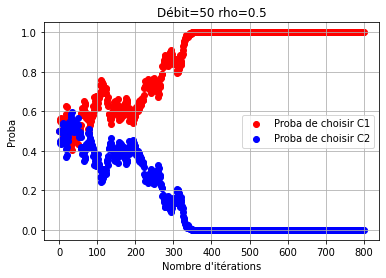

In [6]:
"Pont Binaire de Deneubourg"

C1=0.4 #distance du 1er chemin 
C2=0.4 #distance du 2ème chemin
D=50
rho=0.5

x = [i for i in range(0,801)]
y = choix_de_chemin(C1,C2,800,D,rho)[0]
y2= [1-p for p in y]
plt.scatter(x,y, label= 'Proba de choisir C1',color='red')
plt.scatter(x,y2,label= 'Proba de choisir C2',color='blue')
plt.xlabel("Nombre d'itérations")
plt.ylabel('Proba')
plt.title('Débit='+str(D)+ " rho="+str(rho))
plt.legend()
plt.grid()
plt.show()

On observe bien les fluctuations avant le choix d’un des deux chemins. Ce choix de chemin est effectué de manière aléatoire puisque le chemin choisi différe pour les différents essais que nous avons réalisés dont l'un est représenté au-dessus. 

## 2 ) Le pont binaire à longueurs inégales 

Une deuxième expérience consiste à étudier l’effet de l’utilisation d’un pont avec des branches de longueurs inégales, on choisit ici C1<C2. Avec le mécanisme de dépôt de phéromones, les fourmis ayant emprunté le chemin le plus court arriveront en premier et de ce fait la quantité de phéromones sur ce plus court chemin augmentera davantage que sur le plus long chemin. Cela renforcera alors le choix des autres fourmis de prendre ce plus court chemin. 

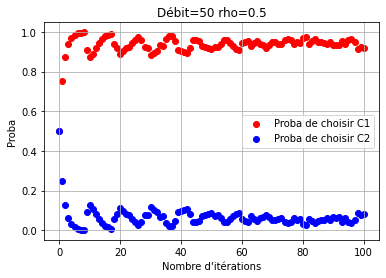

In [7]:

"Pont Binaire à longueurs inégales"

C1=0.4 #distance du 1er chemin 
C2=3.3 #distance du 2ème chemin
# Le rapport entre C1 et C2 est donc de 8 
D=50
rho=0.5

x = [i for i in range(0,101)]
y = choix_de_chemin(C1,C2,100,D,rho)[0]
y2= [1-p for p in y]
plt.scatter(x,y, label= 'Proba de choisir C1',color='red')
plt.scatter(x,y2,label= 'Proba de choisir C2',color='blue')
plt.xlabel("Nombre d'itérations")
plt.ylabel('Proba')
plt.title('Débit='+str(D)+ " rho="+str(rho))
plt.legend()
plt.grid()
plt.show()

On observe des oscillations qui apparaissent à chaque itération multiple de 8. Cela est lié au fait qu’il faut 8 itérations pour que les fourmis ayant choisi le chemin C2 arrivent. Ainsi, plus le rapport entre les 2 chemins C1 et C2 est élevé ($\frac{C1}{C2}$), plus la probabilité de choisir le chemin C1 tend rapidement vers 1. 

# II ) Problème du voyageur de commerce : méthode aprochée par algorithme de colonie de fourmis 

## Description du problème 

L'énoncé du problème du voyageur de commerce est le suivant : "étant donné n points (des « villes ») et les distances séparant chaque point, trouver un chemin de longueur totale minimale qui passe exactement une fois par chaque point et revienne au point de départ." Si l'énoncé du problème semble simple, la méthode naturelle consistant à comparer tous les parcours possibles devient longue, même pour un ordinateur, lorsque le nombre de villes augmente. 

Pour N villes, le nombre de parcours possibles est égal à (N-1)!/2. Par exemple, pour 5 villes, le nombre de parcours est égal à 12, mais pour 20 villes, il est d’environ $6.08 \times 10^{16}$. Si on suppose qu'un ordinateur est capable de déterminer un parcours en une demie microseconde, il mettrait alors 6 microsecondes pour résoudre le problème avec 5 villes mais plus de 950 ans pour celui avec 20 villes. C'est pourquoi on cherche à trouver une solution approchée (la meilleure possible) au problème mais en un temps convenable.

Ce problème peut être modélisé à l’aide d’un graphe composé d’un ensemble de sommets et d’arêtes. Un sommet représente une ville, une arête correspond au passage d’une ville à une autre, et on lui associe un poids qui peut représenter une distance, un temps de parcours ou encore un coût. La résolution du problème consiste donc à trouver, dans ce graphe, un cycle qui passe par tous les sommets une seule et unique fois (on nomme ce cycle un cycle « hamiltonien ») et dont la longueur est minimale. 

Nous avons donc mis en oeuvre une méthode de résolution dite "approchée" avec un algorithme de colonie de fourmis pour tenter de trouver un chemin optimal, proche du chemin le plus court, en un temps nettement inférieur à celui de la méthode naturelle. 

## Modèle mathématique utilisé 

Nous avons utilisé le modèle de Dorigo "Ant System" pour résoudre le problème du Voyageur de commerce avec les colonies de fourmis ("Ant Colony Optimisation" ou ACO).  

La modélisation fonctionne ainsi : on dispose d'**un nombre de fourmis m** représentées chacune par une liste du numéro des villes visitées (parmi un **nombre n de villes**) représentant la mémoire de la fourmi, afin qu'elle ne repasse pas 2 fois par la même ville. A tout **instant t**, chaque fourmi choisit sa prochaine ville selon une probabilité détaillée par la suite. Toutes les fourmis se placent à l’instant t+1 dans une ville de leur choix. Une itération de cet algorithme correspond donc à l’ensemble des déplacements de l’ensemble de la colonie (qui est donc une liste de listes) **entre l’intant t et l’instant t + 1**. Ainsi après **n itérations** (correspondant au nombre de ville choisi), toute la colonie aura réalisé un circuit hamiltonien sur le graphe. Ainsi, toutes les fourmis commencent et finissent leur tour en meme temps. A la fin de chaque cycle, la mémoire de la fourmi est réinitialisée. 

> ### Probabilité de passage d'une ville à une autre

**On note** : $\alpha$ le paramètre caractérisant l'importance des phéromones, **$\beta$** le paramètre caractérisant l'importance de la visibilité de la ville (inverse de la distance), $\tau_{ij}(t)$ la quantité de phéromones déposée par une fourmi entre les villes i et j à la date t, $\eta_{ij}=\frac{1}{d_{ij}}$ la visibilité d'une ville j quand on est localisé au niveau de la ville i (invariante dans le temps). 
**La probabilité pour une fourmi k de passer de la ville i à la ville j à l'instant t vaut** : 

$$p_{ij}^k(t)=\begin{cases}\frac{\tau_{ij}(t)^\alpha\times\eta_{ij}^\beta}{\displaystyle\sum_{l\in N_i^k} \tau_{il}(t)^\alpha\times\eta_{il}^\beta}&\text{si $ j \in N_i^k$}\\0 &\text{sinon}\end{cases}$$ 

où $N_i^k$ est l'ensemble des villes que la fourmi k, placée sur la ville i, n'a pas encore parcourues à l'instant t pendant le cycle. 

> ### Mise à jour des phéromones entre chaque cycle

De plus, à la fin de chaque cycle, les phéromones sont actualisés. On écrit alors, en notant $\rho \in [0,1[$ le taux d'évaporation, i.e. le coefficient définissant la vitesse d'évaporation des phéromones entre les instants $t$ et $t+n$ :

$$\tau_{ij}(t+n)=\rho\times\tau_{ij}(t) + \Delta\tau_{ij}(t),$$ 

**la mise à jour des phéromones à la fin de chaque cycle**, où $\Delta\tau_{ij}(t)$ correspond à la quantité de phéromones déposée sur l'arc $(i,j)$ entre les instants $t$ et $t+n$. 

> ### Quantités de phéromones déposées

La quantité de phéromones déposée par la fourmi k sur l'arc $(i,j)$ dans l'intervalle de temps $[t,t+n]$ s'écrit : 

$$\Delta\tau_{ij}^k(t)=\begin{cases}\frac{Q}{L_k(t)}&\text{si la fourmi k passe par l'arc (i,j) pendant ce cycle}\\0 &\text{sinon}\end{cases},$$

où $Q$ est une constante (d'influence négligeable en pratique) et $L_k(t)$ correspond à la longueur du tour réalisé par la fourmi k pendant ce cycle $[t,t+n]$, i.e. la somme de toutes les distances des arcs $(i,j)$ parcourus dans l'ordre par la fourmi k (en revenant à la fin à la ville initiale). 

Mathématiquement, on voit bien que plus le chemin est court, plus la quantité de phéromones déposés sur l'arc $(i,j)$ est importante, donc les phéromones sont bien adaptés à la qualité de la solution. 

Puis, on a : $$\Delta\tau_{ij}(t)=\displaystyle\sum_{k=1}^m \Delta\tau_{ij}^k(t)$$


**Nous étudierons au fur et à mesure du projet l'influence des différents paramètres sur le modèle**

## Implémentation de l'algorithme 

**Import des modules utilisés**

In [8]:
import numpy as np 
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Test unitaire de la fonction de longueur d'un cycle

On va réaliser un test unitaire sur la fonction distance_1cycle qui nous sert après, dans nos classes, à calculer la longueur d'un cycle réalisé par une fourmi. 

In [9]:
"Calcul de la distance euclidienne entre deux points du plan"

def distance(l1,l2):
        #2 listes de 2 coordonnées
        return np.sqrt((l1[0]-l2[0])**2 + (l1[1]-l2[1])**2)

"Distance parcourue par la fourmi lors d'un cycle"
"(i.e. lorsqu'elle passe une fois par toutes les villes et revient enfin à la ville initiale)"
    
def distance_1cycle(nbre_villes,liste,coord_villes):
    longueur=0
    for k in range(nbre_villes - 1):
        longueur+=distance(coord_villes[liste[k]],coord_villes[liste[k+1]])
    longueur+=distance(coord_villes[liste[0]],coord_villes[liste[-1]]) #on n'oublie pas de relier la première et la dernière vi
    return longueur

In [11]:
"""On trace des rectangles de longueur et largeur aléatoire 
et on vérifie que le chemin faisant le contour du redtangle a pour longueur le périmètre du rectangle"""
import unittest

class TestLongueurCycle(unittest.TestCase):
    def test_LongueurCycle(self):
        for k in range(100):
            x0,y0 = np.random.rand(2) #on part d'un point du plan de coordonnées aléatoires 
            a, b = np.random.rand(2) #on prend deux paramètres a et b aléatoires
            #on trace le rectangle de longeur b et de largeur a (ou inversement selon a<b ou non)
            chemin_rectangle = np.array([[x0,y0],[x0,y0+b],[x0-a,y0+b],[x0-a,y0]])
            longueur=b
            largeur=a
            chemin = [0,1,2,3]
            self.assertAlmostEqual(distance_1cycle(4,chemin,chemin_rectangle), 2*longueur + 2*largeur)
    
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


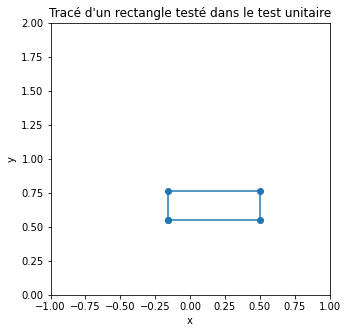

In [12]:
" Tracé du rectangle du test unitaire "

x0,y0 = np.random.rand(2)
a, b = np.random.rand(2)

chemin_rectangle = np.array([[x0,y0],[x0,y0+b],[x0-a,y0+b],[x0-a,y0]])
chemin=[0,1,2,3]
x = [chemin_rectangle[chemin[i]][0] for i in range(-1,len(chemin))]
y = [chemin_rectangle[chemin[i]][1] for i in range(-1,len(chemin))]
plt.figure(figsize=(5,5))
plt.xlim((-1,1))
plt.ylim((0,2))
plt.plot(x,y,'o-')
plt.title("Tracé d'un rectangle testé dans le test unitaire")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Classes Fourmi et ColonieDeFourmis

Le principe de l'algorithme est le suivant : on répartit aléatoirement **m** fourmis sur **n** villes, et chacune des fourmis est représentée par une liste correspondant à sa mémoire qui contient, à l'initialisation, le numéro de la ville initiale et qu'on remplit petit à petit avec les numéros des villes qu'elle parcourt. Au départ, les phéromones sont initialisés avec une matrice de taille $n\times n$ dont tous les éléments prennent la même valeur **c** proche de 0 mais sont non nuls d'après les formules mathématiques (on ne peut pas diviser par 0). A la fin d'un cycle, i.e. au bout de **n** itérations (car les fourmis avancent d'une ville par itération : ainsi, comme elles parcourent toutes n villes, elles reviennent toutes en même temps au point de départ initial), leur liste "mémoire" contenant l'ordre des villes parcourues par chaque fourmi est pleine. Alors, toujours à la fin d'un cycle, chaque fourmi calcule sa valeur $L_k(t)$. Puis, les variables $\tau_{ij}^k(t)$ sont calculées grâce aux formules mathématiques et les variables $\tau_{ij}$ sont actualisées : cela revient en fait à ce que les fourmis fassent à nouveau leur tour en sens inverse tout en déposant leur phéromones. Puis, on regarde quelle fourmi a trouvé le chemin de longueur minimale et on le conserve dans une liste. Enfin, la mémoire des fourmis est effacée avant de commencer le cycle suivant. 

Nous avons codé notre algorithme à l'aide de **deux classes** : **la classe Fourmi** qui renvoie, grâce à la méthode fourmi_1cycle, la liste des n villes parcourues pendant un cycle par une fourmi, et **la classe ColonieDeFourmis** qui permet de réaliser, pour les m fourmis de la colonie, N cycles à l'aide de la méthode N_cycles. Cette classe contient aussi des méthodes permettant des représentations graphiques détaillées dans les commentaires des fonctions et dans la suite du projet.     

La classe Fourmi prend en argument un nombre de villes **n** à parcourir pour le problème du voyageur de commerce, les paramètres alpha et beta, et une matrice de taille $n\times2$ qui contient les coordonnées des villes (dans le plan). Elle contient des attributs notables comme **villes_parcourues** et **villes_non_parcourues** qui sont respectivement la liste des numéros des villes parcourues et celle des numéros des villes non parcourues. Elle reprend, dans les méthodes **ponderation** et **fourmi_1cycle** la formule de la partie Modélisation mathématique "Probabilité de passage d'une ville à une autre" et renvoie une liste correspondant au chemin (liste des numéros de villes parcourues dans un certain ordre au cours d'un cycle) réalisé par une fourmi. 

In [13]:
class Fourmi():
    def __init__(self,coord_villes,nbre_villes,alpha,beta):
        self.nbre_villes=nbre_villes #nombre de villes du problème du Voyageur de commerce
        self.numero_ville_init=random.randint(0,nbre_villes) # numéro de la ville initiale de départ choisi au hasard pour une fourmi
        self.alpha=alpha #paramètre alpha
        self.beta=beta #paramètre beta
        self.villes_parcourues=[self.numero_ville_init] #liste des numéros des villes parcourues : initialement, juste la ville initiale
        self.villes_non_parcourues=list(range(nbre_villes)) #liste des numéros des villes non parcourues
        self.villes_non_parcourues.remove(self.numero_ville_init) #on enlève la ville initiale de la liste des villes non poarcourues
        self.coord_villes=coord_villes #coordonnées dans le plan (x,y) de toutes les villes 


    "Calcul de la distance euclidienne entre deux points du plan"
    def distance(self,l1,l2):
        #2 listes de 2 coordonnées
        return np.sqrt((l1[0]-l2[0])**2 + (l1[1]-l2[1])**2)

    
    " Mise en place du code de la formule des probabilités défini dans le modèle mathématiques"
    "Calcul du numérateur de la probabilité Pij (du modèle mathématique défini plus haut) pour une fourmi k"
    "de passer de la ville i à la ville j au cours d'un cycle"
    
    def ponderation(self,pheromones,nbre_villes,D):
        actual_prob=np.zeros((nbre_villes,nbre_villes))
        actual_prob=(pheromones**self.alpha)*(D**(-self.beta))
        return actual_prob              

    "Détermination de la ville suivante choisie par la fourmi numéro k à l'aide de la fonction pondération" 
    "grâce à la formule des probabilités défini dans la partie Modèle mathématique"
    def fourmi_1cycle(self,mat_prob):
        while len(self.villes_non_parcourues)>0:#tant qu'il reste des villes non parcourues
            #on renvoie la liste des probabilités pour une fourmi de passer de la ville 
            #sur laquelle elle est actuellement située à une des villes non parcourues
            probas=[]
            for j in self.villes_non_parcourues:
                probas.append(mat_prob[self.villes_parcourues[-1]][j])
            probas = probas/np.sum(probas) #afin d'obtenir la probabilité défini dans le modèle mathématique plus haut
            #La fourmi choisit une ville au hasard parmi les villes non parcourues, chacune ayant une pondération différente, déterminée par la fonction ponderation
            ville_suivante=np.random.choice(self.villes_non_parcourues,1,p=probas)[0] 
            #On rajoute le numéro de la ville dans la liste des villes parcourues par la fourmi
            self.villes_parcourues.append(ville_suivante) 
            #On retire cette ville de la liste des villes non parcourues 
            self.villes_non_parcourues.remove(ville_suivante)
        return self.villes_parcourues

La classe ColonieDeFourmis prend, en plus des arguments de la classe Fourmi, le taux d'évaporation $\rho$, le nombre de fourmis m, le paramètre Q, le nombre d'itérations maximal Nmax ainsi que des booléens pour faire apparaître différents graphes détaillés dans les commentaires du code. Elle contient des attributs notables comme **meilleur** qui, après Nmax itérations, est constitué du meilleur chemin (le plus court) réalisé par la meilleure fourmi de la colonie et **D** la matrice des distances entre deux villes qui permet de faire des économies de calcul de longueurs de chemins. La méthode **actualisation** permet d'actualiser le nombre de phéromones après chaque cycle de la colonie de fourmis en utilisant les formules du modèle mathématique décrit plus haut dans le projet (sections "Mise à jour des phéromones entre chaque cycle" et "Quantités de phéromones déposées"). La méthode **N_cycles** permet de réaliser Nmax itérations de l'algorithme. Puis, les autres méthodes **graphe_chemin**, **graphe_best_chemin**, **graph_convergence** et **graph_chemin_moyen** permettent d'afficher différents graphiques détaillés dans les commentaires du code ci-dessous. 

In [14]:
class ColonieDeFourmis():
    def __init__(self,coord_villes,nbre_fourmis,taux_evaporation,Q,nbre_villes,alpha,beta,Nmax,allgraph,graph_conv,graph_chemin_moyenn):
        self.graph_chemin_moyenn=graph_chemin_moyenn # booléen permettant de faire apparaître (ou non) un graphique représentant la longueur moyenne du chemin des fourmis au cours des N cycles
        self.graph_conv=graph_conv # booléen permettant de faire apparaître (ou non) un graphique représentant la longueur du meileur chemin (le plus court) des fourmis à chaque cycle 
        self.allgraph=allgraph # Allgraph est un booléen indique si on veut tous les graphes ou pas : si oui, alors mettre allgraph=True
        self.Nmax=Nmax # nombre maximal de cycles réalisés par la colonie de fourmis
        self.nbre_fourmis=nbre_fourmis # nombre de fourmis
        self.nbre_villes=nbre_villes # nombre de villes
        self.pheromones=np.ones((self.nbre_villes,self.nbre_villes)) * 0.1 # matrice des phéromones : initialement, une matrice contenant uniquement le coefficient 0.1 (proche de 0 mais on ne peut pas le prendre nul à cause des formules)
        self.taux_evaporation=taux_evaporation # taux d'avaporation qui correspond au rho de notre modèle mathématique
        self.Q=Q # paramètre Q défini dans le modèle mathématique
        self.meilleur=None # Meilleur chemin 
        self.numero_ville_init=random.randint(0,nbre_villes) # numéro de la ville initiale de départ choisi au hasard pour une fourmi
        self.alpha=alpha # paramètre alpha
        self.beta=beta # paramètre beta
        self.villes_parcourues=[self.numero_ville_init] # liste des numéros des villes parcourues : initialement, juste la ville initiale
        self.villes_non_parcourues=list(range(nbre_villes)) # liste des numéros des villes non parcourues
        self.villes_non_parcourues.remove(self.numero_ville_init) # on enlève la ville initiale de la liste des villes non poarcourues
        self.coord_villes=coord_villes # coordonnées dans le plan (x,y) de toutes les villes
        self.M=[] # liste initialement vide permettant de calculer, dans la suite du code, le chemin moyen à chaque cycle
        self.D=np.zeros((self.nbre_villes,self.nbre_villes)) #matrice des distances entre les villes i et j 
        for i in range(self.nbre_villes):
            self.D[i][i]=1
            for j in range(self.nbre_villes):
                if j!=i:
                    self.D[i][j]=self.distance(self.coord_villes[i],self.coord_villes[j])               
    "Fonction qui renvoie d'une colonie de m fourmis (i.e. une liste de m listes de taille n=nbre_villes)"     
    def colonie_1cycle(self):
        mat_prob=Fourmi(self.coord_villes,self.nbre_villes,self.alpha,self.beta).ponderation(self.pheromones,self.nbre_villes,self.D)     
        return [Fourmi(self.coord_villes,self.nbre_villes,self.alpha,self.beta).fourmi_1cycle(mat_prob) for k in range(self.nbre_fourmis)]           

    "Calcul de la distance euclidienne entre deux points du plan"
    def distance(self,l1,l2):
        #2 listes de 2 coordonnées
        return np.sqrt((l1[0]-l2[0])**2 + (l1[1]-l2[1])**2)
    
    "Distance parcourue par la fourmi lors d'un cycle (i.e. lorsqu'elle passe une fois par toutes les villes" 
    "et revient enfin à la ville initiale)"
    def distance_1cycle(self,liste):
        longueur=0
        for k in range(self.nbre_villes - 1):
            longueur+=self.D[liste[k]][liste[k+1]]
        longueur+=self.D[liste[0]][liste[-1]]
        return longueur
     

    "Mise à jour des phéromones à chaque cycle"
    def actualisation(self):
        self.chemins = self.colonie_1cycle()
        n = self.nbre_villes #Création de la matrice Delta_pheromones correspondant, dans le modèle mathématiques, à la matrice des DeltaTau_ij(t)
        Delta_pheromones = np.zeros((n,n))
        self.longueurs = np.array([self.distance_1cycle(chemin) for chemin in self.chemins])
        #Calcul de la matrice Delta_pheromones après chaque cycle
        for k in range(self.nbre_fourmis): #on va calculer les Delta_tau_ij^^k(t) du modèle mathématique
            chemin = self.chemins[k] #on s'intéresse au cycle de la fourmi k 
            #print(chemin)
            delta_k=np.zeros((n,n)) #Création de la matrice des Delta_tau_ij^^k(t) du modèle mathématique
            #On applique la formule vue dans le modèle mathématique
            delta_k[chemin[-1]][chemin[0]]=self.Q/self.longueurs[k]
            delta_k[chemin[0]][chemin[-1]]=self.Q/self.longueurs[k]
            for j in range(len(chemin)-1):
                delta_k[chemin[j]][chemin[j+1]]=self.Q/self.longueurs[k]
                delta_k[chemin[j+1]][chemin[j]]=self.Q/self.longueurs[k]
            delta_k=np.array(delta_k)#la matrice Delta_pheromones correspond à la somme de la matrice delta_k pour toutes les fourmis
            Delta_pheromones+=delta_k 
        self.M.append(sum(self.longueurs)/float(len(self.longueurs))) #Longueur du chemin moyen pendant 1 cycle
        #Actualisation des phéromones selon la formule du modèle mathématique
        self.pheromones = self.pheromones * self.taux_evaporation + Delta_pheromones 
         #Chemin le plus court réalisée par une fourmis de la colonie à la fin d'un cycle
        self.meilleur = self.chemins[np.argmin(self.longueurs)]

    "Réalisation des N cycles pour la colonie de fourmis"
    def N_cycles(self):
        L=[]
        C=[]
        for k in tqdm(range(self.Nmax)):
            self.actualisation() 
            L.append(self.distance_1cycle(self.meilleur))
            C.append(self.meilleur)
            if self.allgraph==True:
                self.graphe_chemin(C[-1],L[-1],k)
        self.minL=min(L)
        self.argminL=np.argmin(L)
        self.Cbest=C[np.argmin(L)]
        self.L=L
        self.graphe_best_chemin()
        if self.graph_conv==True:
            self.graph_convergence()
        if self.graph_chemin_moyenn==True:
            self.graph_chemin_moyen()
        
        
### Méthodes pour l'affichage des graphiques ###


    "Fonction utile pour tracer n'importe quel graphe"
    def graphe_chemin(self,chemin, longueur, cycle):
        villes= self.coord_villes
        x = [villes[chemin[i]][0] for i in range(-1,len(chemin))]
        y = [villes[chemin[i]][1] for i in range(-1,len(chemin))]
        fig = plt.figure(figsize = (5,5))
        plt.xlim((-0.1,1.1))
        plt.ylim((-0.1,1.1))
        plt.plot(x, y, color='r')
        plt.scatter(x, y, color = 'g')
        plt.axis('off')
        plt.title("Distance chemin=" + str(longueur) + "n°cycle " + str(cycle))
        plt.show()  


    "Fonction qui permet de tracer le meilleur chemin obtenu et d'afficher sa longueur"
    def graphe_best_chemin(self):
        villes= self.coord_villes
        x = [villes[self.Cbest[i]][0] for i in range(-1,len(self.Cbest))]
        y = [villes[self.Cbest[i]][1] for i in range(-1,len(self.Cbest))]
        fig = plt.figure(figsize = (5,5))
        plt.xlim((-0.1,1.1))
        plt.ylim((-0.1,1.1))
        #Tracé des chemins
        plt.plot(x, y, color='r')
        plt.scatter(x, y, color = 'g')
        plt.axis('off')
        plt.title("Meilleur chemin=" + str(self.minL) + "n°cycle " + str(self.argminL)) #Titre du graphique
        plt.show()     
        
    "Fonction qui permet de représenter la longueur du meilleur chemin (le plus court)"
    "à chaque cycle et ainsi d'étudier la convergence des fourmis bers un chemin minimal"
    def graph_convergence(self):
        plt.plot()
        plt.plot(list(range(self.Nmax)), self.L, "gx-")
        plt.xlabel('nombre de cycle') #Légendes en abscisse
        plt.ylabel('longueur du chemin minimal') #Légende en ordonnée
        plt.title('alpha='+ str(self.alpha)+ 'beta='+str(self.beta)+ 'rho='+str(self.taux_evaporation)) #Titre du graphique
        plt.grid()
        plt.show()

    "Fonction qui permet de représenter la longueur moyenne du chemin de la colonie à chaque cycle"
    def graph_chemin_moyen(self):
        plt.plot(list(range(len(self.M))), self.M , "gx-")
        plt.xlabel('nombre de cycle') #Légendes en abscisse
        plt.ylabel('longueur du chemin moyen') #Légende en ordonnée
        plt.title('alpha='+ str(self.alpha)+ 'beta='+str(self.beta)+ 'rho='+str(self.taux_evaporation)) #Titre du graphique
        plt.grid()
        plt.show()

### Test de la fonction et analyse des résultats 

**Pour exécuter l'algorithme, il suffit de changer (ou non) les paramètres ci-dessous en suivant les indications des commentaires. Nous avons testé l'algorithme pour un nombre de villes compris entre 20 et 150 et avons affiché ici 5 exemples sur respectivement 20 villes françaises, 20 villes aléatoires, 50 villes aléatoires, 75 villes aléatoires et 150 villes aléatoires. Nous avons cherché les meilleurs paramètres à choisir pour que les fourmis trouvent des chemins optimaux.**

Après avoir testé plusieurs valeurs de Q, on constate que son influence est négligeable et nous avons donc fixé sa valeur à 100 (comme notre article cité dans la source nous l'indiquait). 

On a aussi remarqué que $\alpha$, le paramètre caractérisant l'importance des phéromones devait être légèrement au-dessus de $\beta$ pour que la longueur du chemin minimal converge au bout d'un certain nombres d'itérations. 
En effet, en prenant $\beta=1$ et $\alpha=1,2$, on remarque qu'on obtient des chemins tracés convexes donc proches de la longueur minimale (voire égaux) et une convergence de cette distance minimale. 

Lorsque $\alpha$ augmente, l'importance donnée aux phéromones augmente aussi et les fourmis ont donc plus tendance à suivre des chemins déjà réalisés, en d'autres termes cela réduit "l'exploration". Ainsi, on a observé que les fourmis convergaient plus rapidement vers une distance minimale, mais cette distance n'est pas toujours la plus petite. Des valeurs de $\beta$ différentes de 1 donnent des graphiques qui régulièrement ne convergent pas : nous avons donc opté pour $\beta=1$. 

En ce qui concerne le nombre de fourmis, pour des nombres de villes compris entre 20 et 30, utiliser 5 fourmis semble être un nombre adapté de fourmis pour obtenir à la fin un chemin convexe proche du chemin le plus court. Pour un nombre compris entre 50 et 80 villes, nous avons opté pour 10 fourmis et pour plus de 100 villes, nous avons choisi 20 fourmis. On constate que pour un grand nombre de villes, on peut obtenir parfois quelques croisements dans nos graphiques qui témoignent d'un chemin moins optimal qu'avec un tracé convexe : nous précisons quelques axes d'amélioration dans la fin du projet. 

Pour le taux d'évaporation $\rho$, la valeur 0.5 permet aussi des résultats optimaux. 


#### Exemple 1 : 20 villes françaises

  0%|          | 0/1000 [00:00<?, ?it/s]

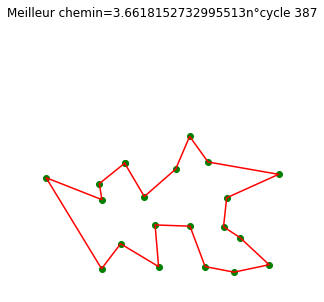

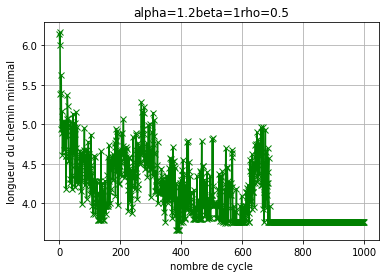

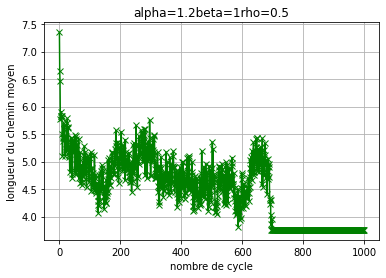

  0%|          | 0/5 [00:00<?, ?it/s]

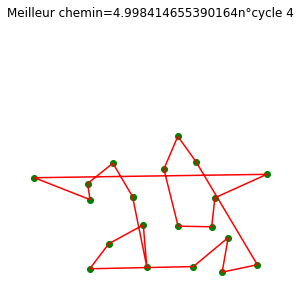

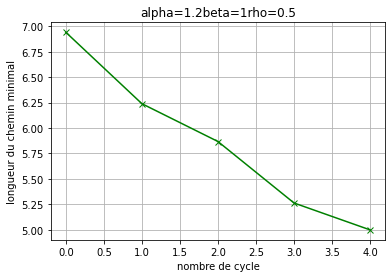

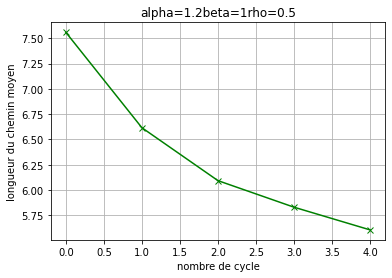

(None, None)

In [16]:
n=20 # Nombre de villes

Villes=np.array([[0.55722067, 0.45504091],
       [0.61716623, 0.59945503],
       [1.        , 0.43188009],
       [0.76294277, 0.20027249],
       [0.8079019 , 0.        ],
       [0.95912806, 0.03269755],
       [0.48365118, 0.02452316],
       [0.32016344, 0.12534058],
       [0.61852857, 0.20299725],
       [0.239782  , 0.32016352],
       [0.        , 0.41689374],
       [0.33787464, 0.48092642],
       [0.46866484, 0.20844687],
       [0.23841957, 0.01498635],
       [0.77656678, 0.32833791],
       [0.42234328, 0.33378745],
       [0.83378749, 0.15258859],
       [0.22888284, 0.39100816],
       [0.68392367, 0.02452316],
       [0.69618525, 0.48637604]])
# Matrice des coordonnées (aléatoires ici) de 20 villes françaises

m=5 # Nombre de fourmis (entre 5 et 10 en général mais ça ne sert à rien de mettre plus de 5 fourmis pour 20 villes)
Q=100 # Paramètre Q du modèle toujours égal à 100 (paramètre d'influence négligeagle)
alpha=1.2 # Paramètre alpha optimal
beta=1 # Paramètre beta optimal
N=1000 # Nombre maximal d'itérations
rho=0.5 # taux d'évaporation rho


c=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,5,False,True,True)
b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)

b.N_cycles(),c.N_cycles()

Comme on l'observe sur les graphiques ci-dessus, on constate que lorsque le tracé est convexe comme dans la première figure, le chemin est plus court que lorsqu'il y a des croisements (comme dans la 2ème figure). Ainsi, on voit sur ce premier exemple qu'au bout de nombreuses itérations, les phéromones déposés permettent aux fourmis de trouver un chemin optimal proche du chemin minimal. 

#### Exemple 2 : 20 villes aléatoires

Comme on le constate sur les graphiques ci-dessous, pour 20 villes, avec 5 fourmis, au bout d'un peu plus de 200 itérations, la longueur du chemin minimal converge vers 3,01 qui semble être proche de la longueur du chemin le plus court car il n'y a pas de croisement qui rallonge la longueur du chemin : le tracé est convexe. 

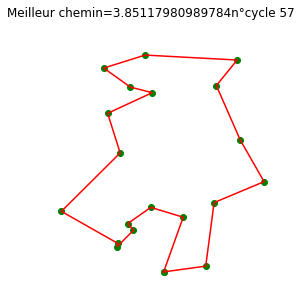

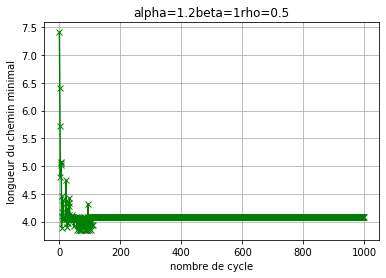

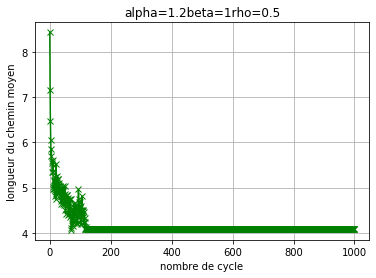

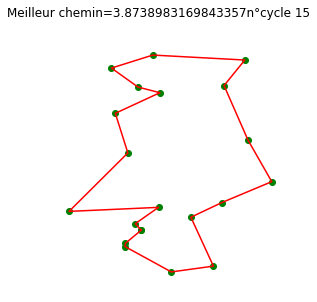

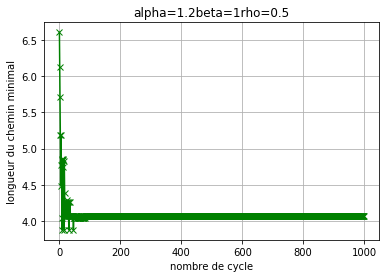

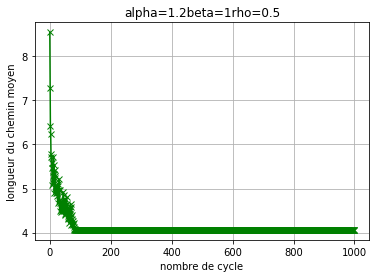

(None, None)

In [20]:
n=20 # Nombre de villes
Villes=np.random.rand(n,2) # Matrice des coordonnées (aléatoires ici) des n villes (ici 20) 
m=10 # Nombre de fourmis (entre 5 et 10 en général mais ça ne sert à rien de mettre plus de 5 fourmis pour 20 villes)
Q=100 # Paramètre Q du modèle toujours égal à 100 (paramètre d'influence négligeagle)
alpha=1.2 # Paramètre alpha optimal
beta=1 # Paramètre beta optimal
N=1000 # Nombre maximal d'itérations
rho=0.5 # taux d'évaporation rho

c=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)
b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)

b.N_cycles(),c.N_cycles()

#### Exemple 3 : 50 villes aléatoires

Comme on le constate sur les graphiques ci-dessous, pour 50 villes, avec 10 fourmis, au bout d'environ 800 itérations, la longueur du chemin minimal converge vers 6,1 qui semble être proche de la longueur du chemin le plus court car le tracé est convexe.

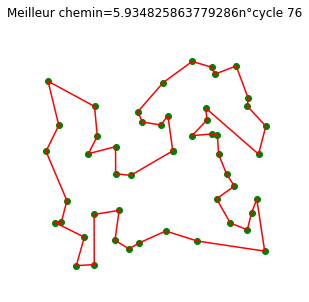

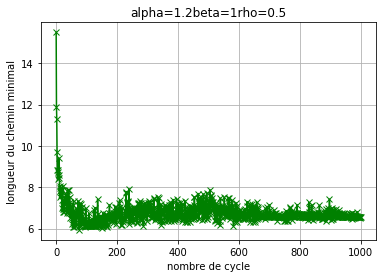

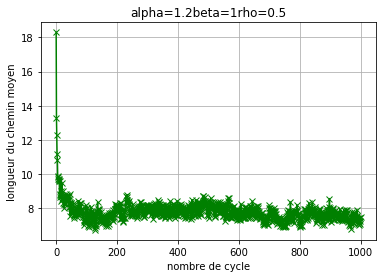

In [30]:
n=50 # Nombre de villes
Villes=np.random.rand(n,2) # Matrice des coordonnées (aléatoires ici) des n villes (ici 50) 
m=10 # Nombre de fourmis (ici 10) 
Q=100 # Paramètre Q du modèle toujours égal à 100 (paramètre d'influence négligeagle)
alpha=1.2 # Paramètre alpha optimal 
beta=1 # Paramètre beta optimal
N=1000 # Nombre maximal d'itérations
rho=0.5 # taux d'évaporation rho

b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)

b.N_cycles() 

#### Exemple 4 : 75 villes aléatoires

Comme on le constate sur les graphiques ci-dessous, pour 75 villes, avec 10 fourmis, au bout d'environ 800 itérations, la longueur du chemin minimal converge vers 7,5 qui semble être proche de la longueur du chemin le plus court car il n'y a pas de croisement qui rallonge la longueur du chemin : le tracé est convexe.

  0%|          | 0/1000 [00:00<?, ?it/s]

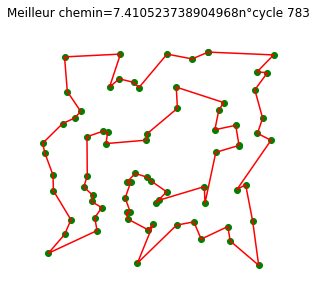

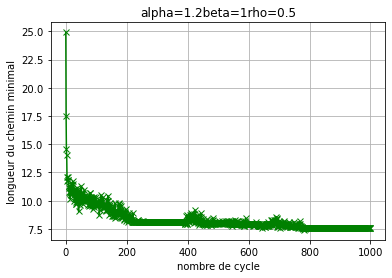

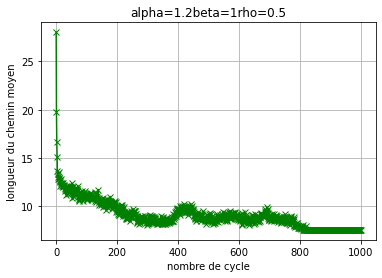

In [82]:
n=75 # Nombre de villes
Villes=np.random.rand(n,2) # Matrice des coordonnées (aléatoires ici) des n villes (ici 20) 
m=10 # Nombre de fourmis (entre 5 et 10 en général mais ça ne sert à rien de mettre plus de 5 fourmis pour 20 villes)
Q=100 # Paramètre Q du modèle toujours égal à 100 (paramètre d'influence négligeagle)
alpha=1.2 # Paramètre alpha 
beta=1 # Paramètre alpha 
N=1000 # Nombre maximal d'itérations
rho=0.5 # taux d'évaporation rho

b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)

b.N_cycles() 

#### Exemple 5 : 150 villes aléatoires

In [141]:
n=150 # Nombre de villes
Villes=np.random.rand(n,2) # Matrice des coordonnées (aléatoires ici) des n villes (ici 150) 

  0%|          | 0/2000 [00:00<?, ?it/s]

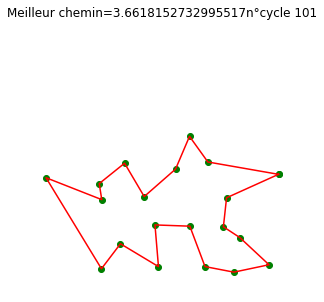

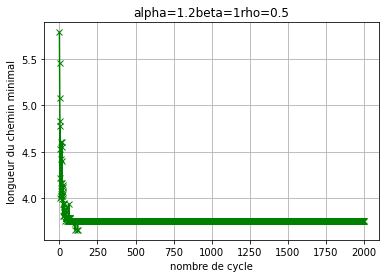

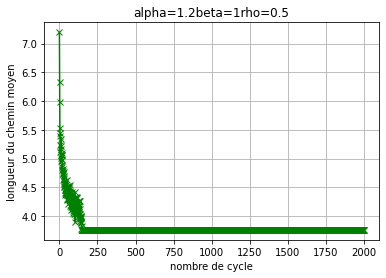

In [17]:
m=20 # Nombre de fourmis (entre 5 et 10 en général mais ça ne sert à rien de mettre plus de 5 fourmis pour 20 villes)
Q=100 # Paramètre Q du modèle toujours égal à 100 (paramètre d'influence négligeagle)
alpha=1.2 # Paramètre alpha 
beta=1 # Paramètre beta 
N=2000 # Nombre maximal d'itérations (ici 2000)
rho=0.5 # taux d'évaporation rho

b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)

b.N_cycles() 

# III ) Problème du voyageur de commerce : prolongements avec fourmis élitistes et variante 

## 1 ) Fourmis élitistes 

Nous proposons d’améliorer la convergence de l’algorithme précédent à l’aide des fourmis élitistes. Cette méthode consiste à renforcer artificiellement les quantités de phéromones sur les arcs du chemin le plus court réalisé à chaque cycle. 

En d’autres termes, une fois que les fourmis ont déposé leurs phéromones à la fin de chaque cycle, d’autres fourmis, cette fois-ci artificielles et appelées fourmis élitistes, parcourent à nouveau le chemin le plus court du cycle. Ces dernières ne partent donc qu'après la fin du tour des autres fourmis, elles choisissent alors leur chemin. 

On appelle $T^*$ le meilleur tour réalisé lors du cycle en question et L* sa longueur. Mathématiquement, cela revient à actualiser une nouvelle fois les phéromones des arcs situés sur le chemin minimal. 

$$\tau_{ij}(t) = \tau_{ij}(t)+\begin{cases}e*\frac{Q}{L^*}&\text{si (i,j) } \in&\text{$T^*$}\\0 &\text{sinon}\end{cases}$$

**Les fourmis élitistes permettent d’accroître la convergence des fourmis. Néanmoins, “forcer la convergence” augmente le risque de converger vers une solution non-optimale.** On favorise ici un chemin parmi ceux déjà explorés.

Concrètement, nous avons repris le code de la partie précédente en ajoutant la fonction **actualisationbis** rendant compte de l’effet des fourmis élitistes. Nous avons également modifié la fonction **N_cycles** maintenant appelée **N_cyclesbis** qui prend en compte les deux actualisations; celle pour les fourmis normales et celle pour les élitistes.


In [21]:
class Elitiste(ColonieDeFourmis):
    # Cela permet de réutiliser toutes les fonctions utilisées dans la classe ColonieDeFourmis
    def __init__(self,coord_villes,nbre_fourmis,taux_evaporation,Q,nbre_villes,alpha,beta,Nmax,allgraph,graph_conv,graph_chemin_moyenn,elitiste):
        self.e=elitiste #correspond on nombre de fourmis élitistes
        super().__init__(coord_villes,nbre_fourmis,taux_evaporation,Q,nbre_villes,alpha,beta,Nmax,allgraph,graph_conv,graph_chemin_moyenn)
        #super().__init__ permet d'initialiser les valeurs afin d'utiliser les fonction de la classe Colonie de fourmis
        self.Mbis=[] # Mbis servira à calculer la moyenne des chemins


    def actualisationbis(self):
        l=self.distance_1cycle(self.meilleur) #il s'agit de la longueur du plus court chemin du cycle en question
        cbest=self.meilleur # cbest correspond au meilleur chemin du cycle en question
        E = np.zeros((n,n)) # E correspond à la matrice des phéromones déposés par les fourmis élitistes
        # On va appliquer la formule du modèle mathématique des fourmis élitistes
        E[cbest[-1]][cbest[0]]=self.e*self.Q/l
        E[cbest[0]][cbest[-1]]=self.e*self.Q/l
        for k in range(len(cbest)-1):
            E[cbest[k]][cbest[k+1]]=self.e*self.Q/l
            E[cbest[k+1]][cbest[k]]=self.e*self.Q/l       
        self.pheromones += E # on ajoute cette matrice à la matrice des phéromones
        self.Mbis.append((sum(self.longueurs)+e*l)/float(len(self.longueurs)+e)) #cela sert 
        
        
    def N_cyclesbis(self):
        #Même fonction que N_cycles mais en servant aussi d'actualisation bis
        L=[]
        C=[]
        for k in tqdm(range(self.Nmax)):
            self.actualisation() 
            self.actualisationbis() # on prend en compte l'actualisation avec les fourmis élitistes
            L.append(self.distance_1cycle(self.meilleur))
            C.append(self.meilleur)
            if self.allgraph==True:
                self.graphe_chemin(C[-1],L[-1],k)
        self.minL=min(L)
        self.argminL=np.argmin(L)
        self.Cbest=C[np.argmin(L)]
        self.L=L
        self.graphe_best_chemin()
        if self.graph_conv==True:
            self.graph_convergence()
        if self.graph_chemin_moyenn==True:
            self.graph_chemin_moyen_bis()
        
   
    def graph_chemin_moyen_bis(self):
        plt.plot(list(range(len(self.Mbis))), self.Mbis , "gx-")
        plt.xlabel('nombre de cycle')
        plt.ylabel('longueur du chemin moyen')
        plt.title('alpha='+ str(self.alpha)+ 'beta='+str(self.beta)+ 'rho='+str(self.taux_evaporation))
        plt.grid()
        plt.show()

#### Comparaison avec et sans fourmis élitistes

On observe pour 20 villes et pour 10 fourmis que la présence de fourmis élitistes permet la convergence vers un chemin proche du chemin optimal. 

In [31]:
n=40 
Villes=np.random.rand(n,2)

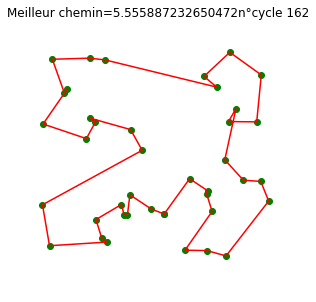

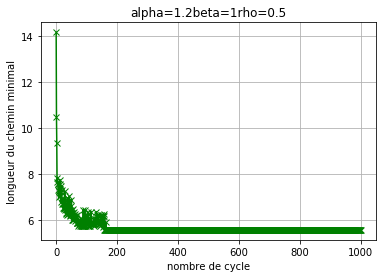

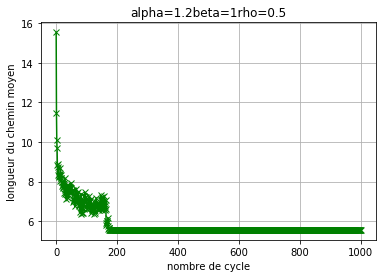

In [32]:
m=10
Q=100
alpha=1.2
beta=1
N=1000
rho=0.5

b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)

b.N_cycles()

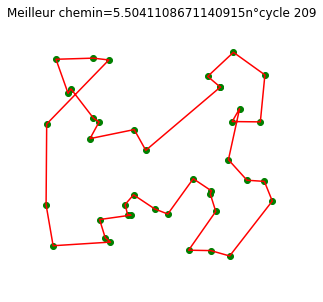

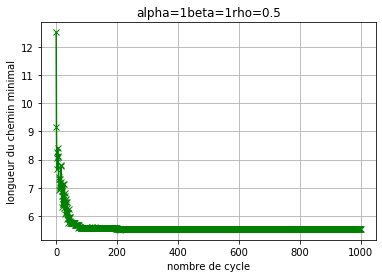

In [33]:
m=10
Q=100
alpha=1
beta=1
N=1000
rho=0.5
e=5 # Nombre de fourmis élitistes 

c1=Elitiste(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,e)

c1.N_cyclesbis()

#### Différence entre une augmentation de alpha et un ajout de fourmis élitistes

On pourrait alors croire qu’ajouter des fourmis élitistes est équivalent à augmenter $\alpha$  dans la partie précédente, sauf qu’ici on ne renforce pas tous les chemins explorés en donnant plus de poids de manière générale aux phéromones : on renforce uniquement le meilleur chemin de chaque cycle en augmentant la quantité de phéromones sur tous les arcs de ce dernier. 

Ainsi, les fourmis élitistes permettent de se focaliser sur les meilleurs tours et donc facilite la recherche du chemin minimal. 

On observe bien au cours des simulations qu’augmenter  $\alpha$ avec les valeurs 1.5 et 2 force la convergence mais vers une valeur éloignée du chemin optimal contrairement à l’ajout des fourmis élitistes qui permet de converger vers un chemin proche du chemin optimal.

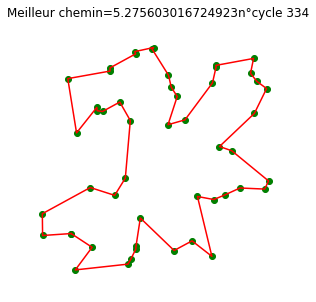

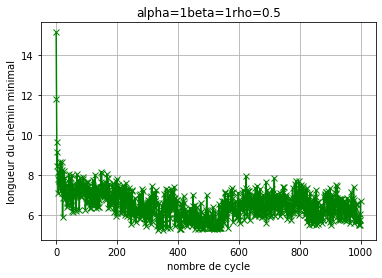

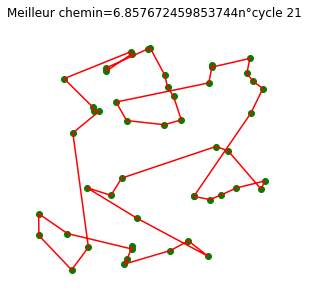

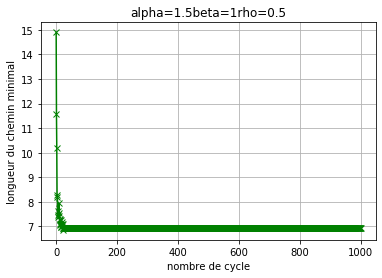

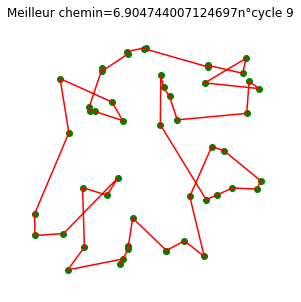

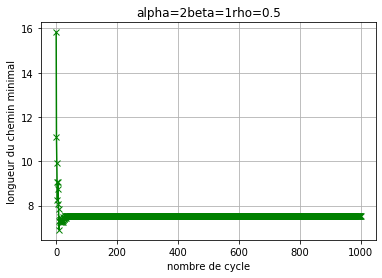

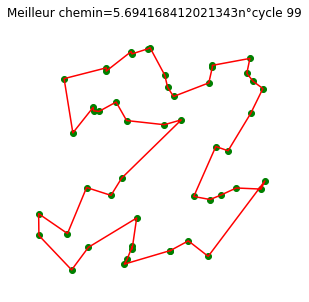

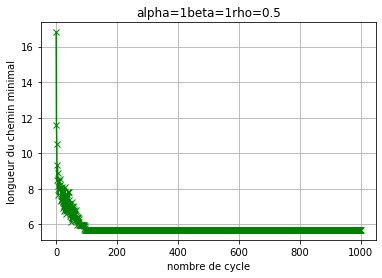

(None, None, None, None)

In [26]:
n=50
Villes=np.random.rand(50,2)
m=10
Q=100
alpha=1
alpha2=1.5
alpha3=2
beta=1
N=1000
e=5 # Nombre de fourmis élitistes
rho=0.5

b1=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,False)
b2=ColonieDeFourmis(Villes,m,rho,Q,n,alpha2,beta,N,False,True,False)
b3=ColonieDeFourmis(Villes,m,rho,Q,n,alpha3,beta,N,False,True,False)
c=Elitiste(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,e)


b1.N_cycles(),b2.N_cycles(),b3.N_cycles(),c.N_cyclesbis()

#### Recherche de la valeur optimale de e 

D’autre part, il y a une valeur optimale de $e^*$, le nombre de fourmis élitistes. Quand le nombre de fourmis élitistes est supérieur à cette valeur, les fourmis élitistes forcent la convergence vers un chemin non-optimal tandis que quand ce nombre est inférieur, un meilleur tour aurait pu être découvert plus tôt ou un tour proche du plus court chemin aurait pu être atteint en nettement moins d'itération.  

Nous observons empiriquement que pour 20 villes avec 10 fourmis, la valeur optimale $e^*$ est égal à 6, comme le montre les graphiques ci-dessous qui correspondent respectivement à 2,4,6 et 10 fourmis élitistes. En effet, avec 2 fourmis élitistes, on obtient un chemin de longueur minimal de longueur 5,13 mais au bout de 212 cycles. Avec 4 fourmis élitistes, on obtient un chemin de longueur 5,23 en 123 cycles alors que pour 6 fourmis élitistes, on obtient un chemin de longueur 5,19 mais au bout de seulement 38 itérations. Enfin, pour 10 fourmis élitistes, on obtient une convergence au bout d'un nombre faible d'itérations (89) mais vers un chemin loin du chemin le plus court (5,44) car il contient des croisements. Ainsi, on voit que 6 fourmis élitistes correspond au meilleur compromis entre longueur minimale et nombre d'itérations/rapidité de la convergence vers un chemin optimal.  

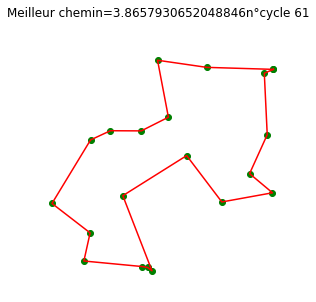

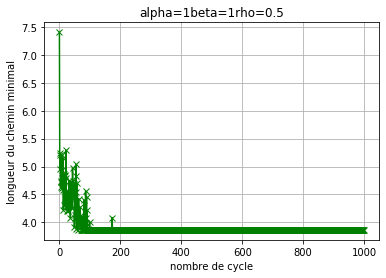

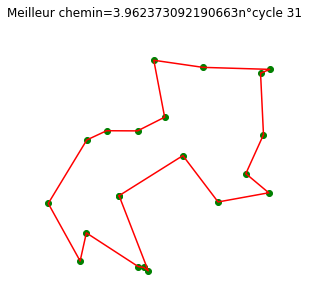

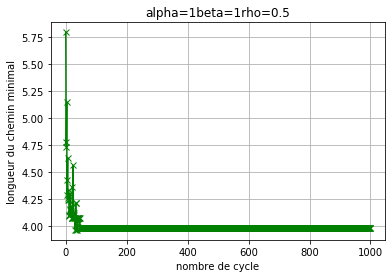

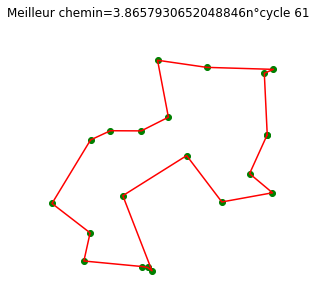

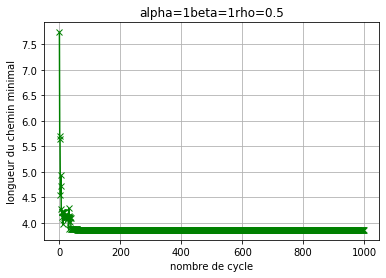

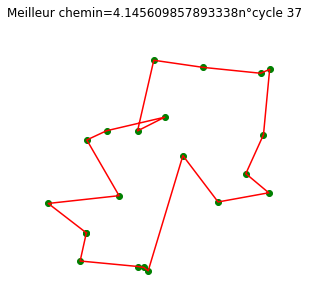

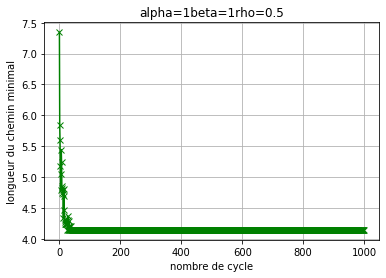

(None, None, None, None)

In [36]:
n=20
Villes=np.random.rand(40,2)
m=10
Q=100
alpha=1
beta=1
N=1000
rho=0.5

#b=ColonieDeFourmis(Villes,m,rho,Q,n,alpha,beta,N,False,True,True)
c=Elitiste(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,2)
c1=Elitiste(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,4)
c2=Elitiste(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,6)
c3=Elitiste(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,10)


c.N_cyclesbis(),c1.N_cyclesbis(),c2.N_cyclesbis(),c3.N_cyclesbis()


## 2 ) Variante 

Pour des grands parcours, on peut reprocher à Ant System de Dorigo de ne pas assez se focaliser sur les meilleures solutions déjà  trouvées sur les cycles précédents.
Une variante, différente de celle utilisant les fourmis élitistes,  nommée Ant Colony System propose une amélioration. On prend maintenant en compte une variable constante $\phi_0 \in [0,1]$. A chaque itération, au moment de choisir la ville suivante, on attribue une valeur $\phi \in [0,1]$. 
Si $\phi≤\phi_0 $ alors  le choix effectué est basé sur les villes déjà visitées.
Dans le cas où $\phi>\phi_0$, le choix est réalisé de la même manière que précédemment. 
Concrètement on reprend le code utilisée pour le modèle d’origine. On modifie fourmi_1cycle en prenant en compte la comparaison entre $\phi$ et $\phi_0$. 

Par exemple, admettons que dans le meilleur chemin au cycle précédent (cycle n-1) la fourmi passe par la ville 18 puis 7. On se place au cycle n, et une fourmi se trouve lors de son chemin à la ville 18 : pour cette itération, si on a $\phi≤\phi_0 $, alors la fourmi ira à la ville 7 à l'itération suivante. 


In [211]:
" Le code est quasiment le même que celui de la partie II) avec les classes Fourmis et "
"ColonieDeFourmis mais nous avons dû le recopier ici car nous faisons intervenir de "
"nouvelles variables dans les fonctions"

class Fourmi2():
    def __init__(self,coord_villes,nbre_villes,alpha,beta,phi_0):
        self.nbre_villes=nbre_villes
        self.numero_ville_init=random.randint(0,nbre_villes)
        self.alpha=alpha
        self.beta=beta
        self.villes_parcourues=[self.numero_ville_init]
        self.villes_non_parcourues=list(range(nbre_villes))
        self.villes_non_parcourues.remove(self.numero_ville_init)
        self.coord_villes=coord_villes
        self.phi_0=phi_0

    def distance(self,l1,l2):
        #2 listes de 2 coordonnées
        return np.sqrt((l1[0]-l2[0])**2 + (l1[1]-l2[1])**2)
    
    def ponderation(self,pheromones,nbre_villes,D):
        actual_prob=np.zeros((nbre_villes,nbre_villes))
        actual_prob=(pheromones**self.alpha)*(D**(-self.beta))
        return actual_prob
                
    'Fonction modifiée par rapport au II)'
    def fourmi_1cycle(self,mat_prob,meilleur):    
        while len(self.villes_non_parcourues)>0:
            phi=random.random() #attribution de phi
            probas=[]
            for j in self.villes_non_parcourues:
                probas.append(mat_prob[self.villes_parcourues[-1]][j])
            probas = probas/np.sum(probas)
            if phi<=self.phi_0 and meilleur!=None: #on compare phi à phi_0 et on traite les cas pathologiques 
                dernier_el_meilleur=meilleur[-1]
                if self.villes_parcourues[-1]==dernier_el_meilleur and meilleur[0] in self.villes_non_parcourues==True :
                    ville_suivante=self.meilleur[0]
                else:
                    dernière_ville=self.villes_parcourues[-1]

                    if dernière_ville!=dernier_el_meilleur:
                        if meilleur[meilleur.index(dernière_ville)+1] in self.villes_non_parcourues:
                            ville_suivante=meilleur[meilleur.index(dernière_ville)+1]
                        else: 
                            ville_suivante=np.random.choice(self.villes_non_parcourues,1,p=probas)[0]
                    else: 
                        ville_suivante=np.random.choice(self.villes_non_parcourues,1,p=probas)[0]
            else:
                ville_suivante=np.random.choice(self.villes_non_parcourues,1,p=probas)[0]
            self.villes_parcourues.append(ville_suivante)
            self.villes_non_parcourues.remove(ville_suivante)
        return self.villes_parcourues


class ColonieDeFourmis2():
    def __init__(self,coord_villes,nbre_fourmis,taux_evaporation,Q,nbre_villes,alpha,beta,Nmax,allgraph,graph_conv,graph_chemin_moyenn,phi_0):
        self.phi_0=phi_0
        self.graph_chemin_moyenn=graph_chemin_moyenn
        self.graph_conv=graph_conv
        self.allgraph=allgraph #Allgraph indique si on veut tous les graphes ou pas si oui alors mettre allgraph=True
        self.Nmax=Nmax
        self.nbre_fourmis=nbre_fourmis
        self.nbre_villes=nbre_villes
        self.pheromones=np.ones((self.nbre_villes,self.nbre_villes)) * 0.1
        self.taux_evaporation=taux_evaporation
        self.Q=Q
        self.meilleur=None
        self.numero_ville_init=random.randint(0,nbre_villes)
        self.alpha=alpha
        self.beta=beta
        self.villes_parcourues=[self.numero_ville_init]
        self.villes_non_parcourues=list(range(nbre_villes))
        self.villes_non_parcourues.remove(self.numero_ville_init)
        self.coord_villes=coord_villes
        self.M=[]
        self.D=np.zeros((self.nbre_villes,self.nbre_villes))
        for i in range(self.nbre_villes):
            self.D[i][i]=1
            for j in range(self.nbre_villes):
                if j!=i:
                    self.D[i][j]=self.distance(self.coord_villes[i],self.coord_villes[j])


    def colonie_1cycle(self):
        mat_prob=Fourmi2(self.coord_villes,self.nbre_villes,self.alpha,self.beta,self.phi_0).ponderation(self.pheromones,self.nbre_villes,self.D)
        return [Fourmi2(self.coord_villes,self.nbre_villes,self.alpha,self.beta,self.phi_0).fourmi_1cycle(mat_prob,self.meilleur) for k in range(self.nbre_fourmis)]
        
    def distance(self,l1,l2):
        #2 listes de 2 coordonnées
        return np.sqrt((l1[0]-l2[0])**2 + (l1[1]-l2[1])**2)
    
    def distance_1cycle(self,liste):
        longueur=0
        for k in range(self.nbre_villes - 1):
            longueur+=self.D[liste[k]][liste[k+1]]
        longueur+=self.D[liste[0]][liste[-1]]
        return longueur
     
    def actualisation(self):
        self.chemins = self.colonie_1cycle()
        n = self.nbre_villes
        Delta_pheromones = np.zeros((n,n))
        self.longueurs = np.array([self.distance_1cycle(chemin) for chemin in self.chemins])
        for k in range(self.nbre_fourmis):
            chemin = self.chemins[k]
            #print(chemin)
            delta_k=np.zeros((n,n))
            delta_k[chemin[-1]][chemin[0]]=self.Q/self.longueurs[k]
            delta_k[chemin[0]][chemin[-1]]=self.Q/self.longueurs[k]
            for j in range(len(chemin)-1):
                delta_k[chemin[j]][chemin[j+1]]=self.Q/self.longueurs[k]
                delta_k[chemin[j+1]][chemin[j]]=self.Q/self.longueurs[k]
            delta_k=np.array(delta_k)
            Delta_pheromones+=delta_k
        #print(np.shape(Delta_pheromones.shape))
        #print(np.shape(self.pheromones))
        self.M.append(sum(self.longueurs)/float(len(self.longueurs)))
        self.pheromones = self.pheromones * self.taux_evaporation + Delta_pheromones
        self.meilleur = self.chemins[np.argmin(self.longueurs)]

        
    "Affichage des graphiques"

    def graphe_chemin(self,chemin, longueur, cycle):
        villes= self.coord_villes
        x = [villes[chemin[i]][0] for i in range(-1,len(chemin))]
        y = [villes[chemin[i]][1] for i in range(-1,len(chemin))]
        fig = plt.figure(figsize = (5,5))
        plt.xlim((-0.1,1.1))
        plt.ylim((-0.1,1.1))
        plt.plot(x, y, color='r')
        plt.scatter(x, y, color = 'g')
        plt.axis('off')
        plt.title("Distance chemin=" + str(longueur) + "n°cycle " + str(cycle))
        plt.show()  

    def graphe_best_chemin(self):
        villes= self.coord_villes
        x = [villes[self.Cbest[i]][0] for i in range(-1,len(self.Cbest))]
        y = [villes[self.Cbest[i]][1] for i in range(-1,len(self.Cbest))]
        fig = plt.figure(figsize = (5,5))
        plt.xlim((-0.1,1.1))
        plt.ylim((-0.1,1.1))
        plt.plot(x, y, color='r')
        plt.scatter(x, y, color = 'g')
        plt.axis('off')
        plt.title("Meilleur chemin=" + str(self.minL) + "n°cycle " + str(self.argminL))
        plt.show()     
        
    def N_cycles(self):
        L=[]
        C=[]
        for k in tqdm(range(self.Nmax)):
            self.actualisation() 
            L.append(self.distance_1cycle(self.meilleur))
            C.append(self.meilleur)
            if self.allgraph==True:
                self.graphe_chemin(C[-1],L[-1],k)
        self.minL=min(L)
        self.argminL=np.argmin(L)
        self.Cbest=C[np.argmin(L)]
        self.L=L
        self.graphe_best_chemin()
        if self.graph_conv==True:
            self.graph_convergence()
        if self.graph_chemin_moyenn==True:
            self.graph_chemin_moyen()
        
    def graph_convergence(self):
        plt.plot()
        plt.plot(list(range(self.Nmax)), self.L, "gx-")
        plt.xlabel('nombre de cycle')
        plt.ylabel('longueur du chemin minimal')
        plt.title('alpha='+ str(self.alpha)+ 'beta='+str(self.beta)+ 'rho='+str(self.taux_evaporation))
        plt.grid()
        plt.show()

    def graph_chemin_moyen(self):
        plt.plot(list(range(len(self.M))), self.M , "gx-")
        plt.xlabel('nombre de cycle')
        plt.ylabel('longueur du chemin moyen')
        plt.title('alpha='+ str(self.alpha)+ 'beta='+str(self.beta)+ 'rho='+str(self.taux_evaporation))
        plt.grid()
        plt.show()    

  0%|          | 0/1000 [00:00<?, ?it/s]

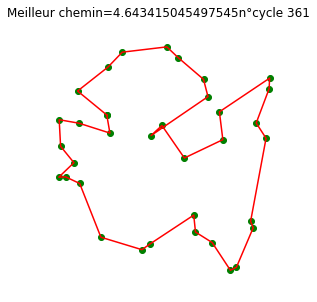

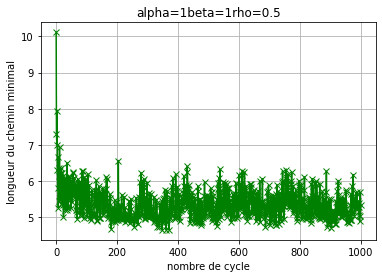

  0%|          | 0/1000 [00:00<?, ?it/s]

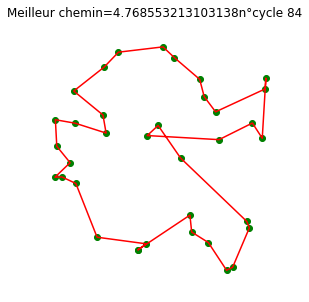

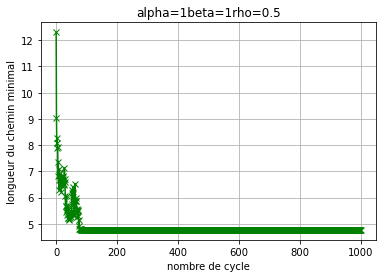

  0%|          | 0/1000 [00:00<?, ?it/s]

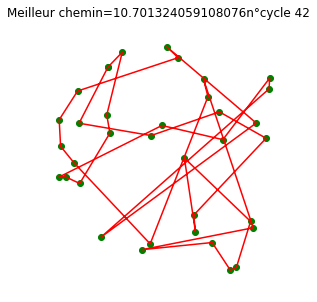

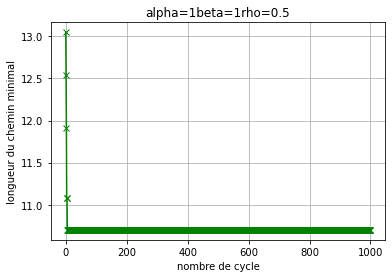

(None, None, None)

In [212]:
"On teste différentes valeurs de phi_0 : les 2 cas limites et la valeur optimale trouvée empiriquement en faisant plusieurs tests"

n=35
Villes=np.random.rand(n,2)
m=10
Q=100
alpha=1
beta=1
N=1000
rho=0.5

c=ColonieDeFourmis2(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,0) #sans la variante i.e. avec phi_0=0
c1=ColonieDeFourmis2(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,0.4) # avec la constante optimale phi_0=0.4
c2=ColonieDeFourmis2(Villes,m,rho,Q,n,alpha,beta,N,False,True,False,1) # cas limite avec phi_0=1

c.N_cycles(),c1.N_cycles(),c2.N_cycles()

# IV ) Difficultés rencontrées et axes d'amélioration

## 1 ) Difficultés rencontrées

Une fois le modèle mathématique compris pour l'élaboration de l'algorithme de résolution du problème du Voyageur de commerce, nous avons d'abord codé notre algorithme sans utiliser de classe. Nous avons décidé ensuite de le coder en classe afin d'organiser plus proprement notre code et de mieux comprendre comment les classes fonctionnent, et les maîtriser nous a pris un peu de temps. 

De plus, le réflexe d'utiliser régulièrement dans notre code des $print()$ nous a permis de détecter nos erreurs au cours du code et ainsi d'avancer plus vite. 

Enfin, la recherche des bons paramètres à utiliser pour obtenir le chemin optimal dans le TSP ainsi que l'optimisation du temps d'exécution de nos algorithmes a necessité beaucoup de temps. 

## 2 ) Optimisation du temps d'exécution de notre algorithme

Après avoir fini de coder l’algorithme de Dorigo, notre plus gros problème était le temps d’exécution. En effet, pour faire 1000 itérations avec 10 fourmis et 20 villes, nous devions attendre environ 1min 10sec. 

Nous avons progressivement réussi à réduire ce temps d’exécution. Tout d’abord, pour chaque fourmi nous recalculions la matrice de distances, ce qui était très couteux en matière d’opérations. Nous avons donc mis toutes ces distances dans une matrice de distances notée D dans notre code. Cela nous a permis de réduire le temps de moitié. Pour faire 1000 itérations avec 10 fourmis, le temps d’exécution n’était plus que de 32 sec.

Ensuite, dans la fonction **ponderation** nous parcourions élément par élément de la matrice phéromones avec une double boucle for. Nous avons donc utilisé le module numpy pour réaliser tous les calculs  en même temps. Finalement, notre temps d’exécution pour 1000 itérations avec 10 fourmis est de 7 sec. 

## 3 ) Axes d'amélioration 

Nous avons constaté que, pour un grand nombre de villes, on obtenait parfois un plus court chemin avec des croisements, ce qui signifie qu'il n'est pas optimal et qu'on pourrait trouver un chemin plus court. Cependant, on remarque qu'il y a très souvent peu de croisements. Ainsi, on pourrait corriger cette erreur en créant une fonction qui, pour des villes dans le plan (2 coordonnées), détecte les endroits où il y a des croisements dans le tracé du chemin et qui inverse deux points bien choisis afin de supprimer ce croisement et d'obtenir un chemin nécessairement plus court que celui avec croisement. 

# Conclusion 

Ce projet nous a permis de manipuler les classes et nous a poussés à sans cesse tenter d'optimiser notre code afin de réduire le temps de calcul lors de la résolution du problème du Voyageur de commerce par la méthode approchée des colonies de fourmis.

De plus, nous avons pris goût à étudier le comportement des fourmis et l'impact de leur phéromones, et nous avons apprécié appliquer le principe des phéromones pour résoudre le problème du Voyageur de commerce. 

En effet, les colonies de fourmis, et plus généralement le comportement animal et l'environnement, sont des sources d'inspiration en informatique de plus en plus développées qui permettent de résoudre des problèmes très divers. Avoir étudié ce sujet nous a ouvert les yeux sur l'efficacité de ces nouvelles méthodes et confirme ainsi la phrase de Bernard Werber dans son ouvrage *Les Fourmis* : "La meilleure voie pour renouveler la pensée est de sortir de l'imagination humaine.".

# Sources 

Article principal dont nous nous sommes inspirés : https://www.i3s.unice.fr/~crescenz/publications/travaux_etude/colonies_fourmis-200605-rapport.pdf
Autre article utilisé : https://interstices.info/le-probleme-du-voyageur-de-commerce/